In [2]:
import os 
os.environ["KERAS_BACKEND"] = "tensorflow"   # Set Keras backend to TensorFlow
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from keras import datasets , layers , models

2025-11-12 15:39:35.768777: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
(train_ds , val_ds , test_ds) , ds_info = tfds.load(
    'tf_flowers' , 
    split = ['train[:80%]' , 'train[80%:90%]' , 'train[90%:]'] , 
    as_supervised = True , 
    with_info = True
)   # Load the TF Flowers dataset and split it into training, validation, and test sets.

In [ ]:
# Print dataset information
print("Num classes:", ds_info.features['label'].num_classes)     
print("Class names:", ds_info.features['label'].names)            
print("Train/Val/Test sizes (approx):",
      ds_info.splits['train'].num_examples * 0.8,
      ds_info.splits['train'].num_examples * 0.1,
      ds_info.splits['train'].num_examples * 0.1)

Num classes: 5
Class names: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
Train/Val/Test sizes (approx): 2936.0 367.0 367.0


In [7]:
# preprocessing and batching (resize + normalization)

IMG_SIZE = 128
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(image , label):
    image = tf.image.resize(image , (IMG_SIZE , IMG_SIZE))  # Resize the image to the specified size (128x128).
    image = tf.cast(image , tf.float32) / 255.0   # Normalize pixel values to the range [0, 1] by dividing by 255.0.
    return image , label


train_ds = (train_ds
            .map(preprocess, num_parallel_calls=AUTOTUNE)  # map preprocessing
            .shuffle(1000)                                 # shuffle for generalization
            .batch(BATCH_SIZE)                             # batch once
            .prefetch(AUTOTUNE))                           # overlap prep & compute

val_ds = (val_ds
          .map(preprocess, num_parallel_calls=AUTOTUNE)
          .batch(BATCH_SIZE)
          .prefetch(AUTOTUNE))

test_ds = (test_ds
           .map(preprocess, num_parallel_calls=AUTOTUNE)
           .batch(BATCH_SIZE)
           .prefetch(AUTOTUNE))


In [ ]:
#Building the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),                                      # classifier head 
    layers.Dense(128, activation='relu'),
    layers.Dense(ds_info.features['label'].num_classes, activation='softmax')  # 5 flower classes
])


/opt/anaconda3/envs/anaconda-nlp/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,288,325 (16.36 MB)

 Trainable params: 4,288,325 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
#Compiling the model
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [12]:
history = model.fit(
    train_ds , 
    validation_data = val_ds , 
    epochs = 15
    
)

Epoch 1/15


2025-11-12 15:57:02.297256: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


92/92 ━━━━━━━━━━━━━━━━━━━━ 50s 507ms/step - accuracy: 0.3385 - loss: 1.5338 - val_accuracy: 0.6158 - val_loss: 1.0760
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 57s 619ms/step - accuracy: 0.5871 - loss: 1.0299 - val_accuracy: 0.6458 - val_loss: 0.9065
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 53s 576ms/step - accuracy: 0.6466 - loss: 0.9057 - val_accuracy: 0.6703 - val_loss: 0.8231
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 54s 588ms/step - accuracy: 0.7244 - loss: 0.7314 - val_accuracy: 0.6403 - val_loss: 0.8754
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 51s 550ms/step - accuracy: 0.8098 - loss: 0.5103 - val_accuracy: 0.6594 - val_loss: 0.8541
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 50s 540ms/step - accuracy: 0.8449 - loss: 0.4241 - val_accuracy: 0.6703 - val_loss: 1.0318
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 52s 563ms/step - accuracy: 0.9324 - loss: 0.2186 - val_accuracy: 0.6594 - val_loss: 1.3151
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 56s 604ms/step - accuracy: 0.9560 - loss: 0.1446 - val_accuracy: 0.659

In [ ]:
test_loss , test_acc = model.evaluate(test_ds)
print("Test accuracy : {test_acc :.3f}")

2025-11-12 16:14:26.608261: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-11-12 16:14:26.611126: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


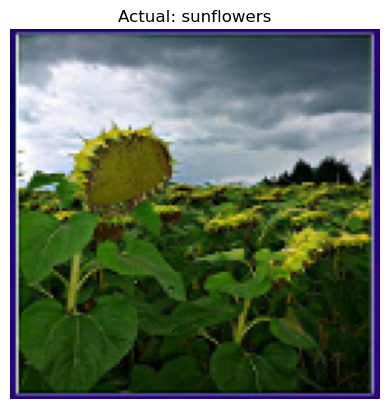

In [14]:
import random

# Visualize a random test image and its labels
test_images_buf = []
test_labels_buf = []
for imgs , lbls in test_ds.take(2):  # take two batch from the test dataset
    test_images_buf.extend(imgs.numpy())  # convert to numpy and store in buffer
    test_labels_buf.extend(lbls.numpy())
class_names = ds_info.features['label'].names             # get flower class names from TFDS
rnd = random.randint(0, len(test_images_buf) - 1)         # random index
plt.imshow(test_images_buf[rnd])                          # show the RGB image
plt.title('Actual: ' + class_names[int(test_labels_buf[rnd])])  # show the ground-truth label name
plt.axis('off')
plt.show()

In [16]:
class_names = ds_info.features['label'].names

images , labels = next(iter(test_ds))
predictions = model.predict(images)

2025-11-12 16:19:17.014621: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#  All predictions and true labels from the test dataset
y_true = []      # store true labels
y_pred = []      # store predicted labels


In [34]:

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())                     # true labels
    y_pred.extend(np.argmax(preds, axis=1))           # predicted class index

y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


In [35]:
y_true[:5]

array([4, 0, 0, 2, 0])

In [36]:
y_pred[:5]

array([2, 0, 0, 1, 0])

<Figure size 800x800 with 0 Axes>

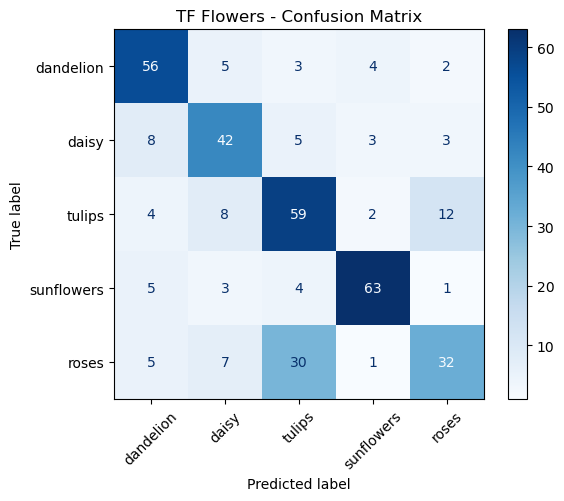

In [37]:


# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred )  # Normalize the confusion matrix by true labels
class_names = ds_info.features['label'].names         # flower class names


# Display the confusion matrix
plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45, values_format='d')
plt.title("TF Flowers - Confusion Matrix")
plt.show()